In [18]:
import pandas as pd
import collections
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

In [2]:
df = pd.read_parquet('resources/extended_dataset.parquet').set_index('Inspection ID')
df.head(2)

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,...,Re-inspection,Community,Neighborhood,Ward,Precinct,Violation IDs,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Inspection ID,,,,,,,,,,,,,,,,,,,,,
2320519,SALAM RESTAURANT,SALAM RESTAURANT,2002822,Restaurant,High,4634-4636 N KEDZIE AVE,60625,2019-10-25,Complaint,Pass,...,True,ALBANY PARK,"NORTH PARK,ALBANY PARK",33,27,[None],0,0,0,0
2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,...,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,"[3, 5, 25, 50, 53, 53, 56, 58]",8,2,1,5


In [3]:
df['Inspection Type'].unique()

array(['Complaint', 'License', 'Canvass', 'Others',
       'Suspect food poisoning', 'Cancelled', 'Consultation', 'Unknown',
       'Task-force'], dtype=object)

In [4]:
df['Facility Type'].unique()

array(['Restaurant', 'Childrens services facility', 'Daycare (2-6 yo)',
       'Grocery store', 'Daycare (0-6 yo)', 'Liquor store', 'Caterer',
       'Mobile food dispenser', 'Sweetshop', 'Bakery', 'Tavern',
       'Long term care center', 'Unknown', 'Others', 'School',
       'Banquet hall', 'Golden Dinner', 'Hospital', 'Daycare (0-2 yo)',
       'Daycare (others)', 'Gas station', 'Wholesaler', 'Shared kitchen',
       'Rooftop', 'Coffee shop', 'Shelter'], dtype=object)

In [5]:
df['Results'] = df['Results'].map(lambda x: x if x != 'Pass w/ Conditions' else 'Pass')
df['Results'].unique()

array(['Pass', 'Fail', 'Not Ready', 'No Entry', 'Out of Business',
       'Business Not Located'], dtype=object)

In [6]:
facility_types_to_keep = ['Restaurant', 'Coffe shop', 'Tavern', 'Rooftop']
results_to_keep = ['Fail', 'Pass']
old_len = len(df)
df = df.dropna(subset=['AKA Name'])
df = df[df['Re-inspection'] == False]
df = df[df['Facility Type'].map(lambda x: x in facility_types_to_keep)]
df = df[df['Results'].map(lambda x: x in results_to_keep)]
df = df[df['Inspection Type'] != 'Cancelled']
print('We have thrown away {}% of the inspections'.format((1 - len(df)/old_len) * 100))

We have thrown away 54.067467040614716% of the inspections


In [7]:
def remove_special_chars(string):
    return ''.join(e for e in string if e.isalnum()).upper()

def standardize_names(string):
    if 'MCDONALDS' in string:
        return 'MCDONALDS'
    elif 'SUBWAY' in string:
        return 'SUBWAY'
    elif 'POTBELLYSANDWICH' in string:
        return 'POTBELLYSANDWICH'
    elif 'POPEYES' in string:
        return 'POPEYES'
    elif 'DUNKINDONUTS' in string:
        return 'DUNKINDONUTS'
    elif 'BURGERKING' in string:
        return 'BURGERKING'
    elif 'WENDYS' in string:
        return 'WENDYS'
    elif 'STARBUCKS' in string:
        return 'STARBUCKS'
    elif 'PIZZAHUT' in string:
        return 'PIZZAHUT'
    elif 'KFC' in string or 'KENTUCKYFRIEDCHICKEN' in string:
        return 'KFC'
    elif 'HAROLDSCHICKEN' in string:
        return 'HAROLDSCHICKEN'
    elif '7ELEVEN' in string:
        return '7ELEVEN'
    elif 'JJFISH' in string:
        return 'JJFISH'
    elif 'DOMINOS' in string:
        return 'DOMINOS'
    elif 'CHIPOTLE' in string:
        return 'CHIPOTLE'
    return string

In [8]:
df['AKA Name'] = df['AKA Name'].map(lambda x: standardize_names(remove_special_chars(x)) if x is not None else None)

In [9]:
nb_licenses_by_aka_dict = {}
for name in df['AKA Name'].unique():
    nb_uniques = len(df[df['AKA Name'] == name].groupby('License #'))
    nb_licenses_by_aka_dict[name] = nb_uniques

In [10]:
nb_licenses_by_aka = pd.DataFrame(nb_licenses_by_aka_dict.items(), columns=['AKA Name', 'Nb Licenses']).set_index('AKA Name').sort_values('Nb Licenses', ascending=False)
nb_licenses_by_aka.head(10)

,Nb Licenses
AKA Name,
SUBWAY,393
DUNKINDONUTS,270
STARBUCKS,240
MCDONALDS,175
BURGERKING,102
KFC,83
HAROLDSCHICKEN,68
POPEYES,58
PIZZAHUT,57


In [11]:
nb_inspections_by_aka = df[['AKA Name', 'DBA Name']].groupby('AKA Name').count().rename(columns={'DBA Name' : 'Nb Inspections'}).sort_values('Nb Inspections', ascending=False)
nb_passed_inspections_by_aka = df[df['Results'] == 'Pass'][['AKA Name', 'Results']].groupby('AKA Name').count().rename(columns={'Results' : 'Nb Passed Inspections'})
nb_failed_inspections_by_aka = df[df['Results'] == 'Fail'][['AKA Name', 'Results']].groupby('AKA Name').count().rename(columns={'Results' : 'Nb Failed Inspections'})
mean_nb_violations_by_aka = df[['AKA Name', 'Nb Violations']].groupby('AKA Name').mean().rename(columns={'Nb Violations' : 'Mean Nb Violations'})
mean_nb_high_violations_by_aka = df[['AKA Name', 'Nb Violations of high severity']].groupby('AKA Name').mean().rename(columns={'Nb Violations of high severity' : 'Mean Nb Violations of high severity'})
mean_nb_medium_violations_by_aka = df[['AKA Name', 'Nb Violations of medium severity']].groupby('AKA Name').mean().rename(columns={'Nb Violations of medium severity' : 'Mean Nb Violations of medium severity'})
mean_nb_low_violations_by_aka = df[['AKA Name', 'Nb Violations of low severity']].groupby('AKA Name').mean().rename(columns={'Nb Violations of low severity' : 'Mean Nb Violations of low severity'})

In [12]:
def retrieve_violation_ids(serie):
    result = {}
    for violation_ids in serie:
        for violation_id in violation_ids:
            if violation_id != 'None':
                violation_id = int(violation_id)
                if violation_id in result:
                    result[violation_id] += 1
                else:
                    result[violation_id] = 1
    return collections.OrderedDict(sorted(result.items()))

violations_ids_by_aka = df[['AKA Name', 'Violation IDs']].groupby('AKA Name').agg(lambda x: retrieve_violation_ids(x)).rename(columns={'Violation IDs' : 'Dist Violation IDs'})
violations_ids_by_aka.head()

,Dist Violation IDs
AKA Name,
1000LIQUORSBIGCITYTAP,"{3: 1, 4: 1, 5: 1, 10: 1, 12: 1, 16: 3, 21: 1,..."
10PINBOWLINGLOUNGE,"{2: 2, 3: 1, 4: 1, 5: 1, 10: 1, 16: 1, 18: 1, ..."
1104WABASH,"{34: 1, 35: 1, 38: 2}"
111COFFEEBAR,"{2: 1, 3: 2, 5: 1, 23: 1, 36: 1, 37: 1, 47: 1,..."
111THSTREETOTB,"{2: 1, 3: 1, 11: 1, 18: 2, 30: 2, 31: 1, 32: 3..."


In [13]:
def retrieve_inspections_types(serie):
    result = {}
    for inspection_type in serie:
        if inspection_type in result:
            result[inspection_type] += 1
        else:
            result[inspection_type] = 1
    return collections.OrderedDict(sorted(result.items()))
    
inspections_types_by_aka = df[['AKA Name', 'Inspection Type']].groupby('AKA Name').agg(lambda x: retrieve_inspections_types(x)).rename(columns={'Inspection Type' : 'Dist Inspections Types'})
inspections_types_by_aka.head()

,Dist Inspections Types
AKA Name,
1000LIQUORSBIGCITYTAP,"{'Canvass': 6, 'Complaint': 4}"
10PINBOWLINGLOUNGE,"{'Canvass': 7, 'Complaint': 2}"
1104WABASH,"{'Complaint': 1, 'License': 2}"
111COFFEEBAR,{'License': 2}
111THSTREETOTB,"{'Canvass': 5, 'Complaint': 1, 'Task-force': 2}"


In [14]:
df_joined = nb_inspections_by_aka.join(nb_licenses_by_aka).join(nb_passed_inspections_by_aka.join(nb_failed_inspections_by_aka)).join(mean_nb_violations_by_aka.join(mean_nb_high_violations_by_aka).join(mean_nb_medium_violations_by_aka).join(mean_nb_low_violations_by_aka)).join(violations_ids_by_aka).join(inspections_types_by_aka)
df_joined['Mean Nb Inspections'] = df_joined['Nb Inspections'] / df_joined['Nb Licenses']
df_joined['Mean Percent Passed Inspections'] = ((df_joined['Nb Passed Inspections'] / df_joined['Nb Licenses']) / df_joined['Mean Nb Inspections'] * 100).fillna(0.0)
df_joined['Mean Percent Failed Inspections'] = 100 - df_joined['Mean Percent Passed Inspections']
df_joined = df_joined.drop(['Nb Passed Inspections', 'Nb Failed Inspections'], axis=1)

def size_category(nb_addresses):
    if nb_addresses >= 100:
        return 'Huge'
    if nb_addresses >= 20:
        return 'Large'
    elif nb_addresses >= 5:
        return 'Medium'
    else:
        return 'Small'
    
df_joined['Size'] = df_joined['Nb Licenses'].map(size_category)

df_joined.head(10)

,Nb Inspections,Nb Licenses,Mean Nb Violations,Mean Nb Violations of high severity,Mean Nb Violations of medium severity,Mean Nb Violations of low severity,Dist Violation IDs,Dist Inspections Types,Mean Nb Inspections,Mean Percent Passed Inspections,Mean Percent Failed Inspections,Size
AKA Name,,,,,,,,,,,,
SUBWAY,3239,393,2.931460,0.354122,0.332819,2.244520,"{1: 24, 2: 162, 3: 448, 4: 11, 5: 191, 6: 53, ...","{'Canvass': 2385, 'Complaint': 571, 'Consultat...",8.241730,83.976536,16.023464,Huge
DUNKINDONUTS,1831,270,3.416712,0.294921,0.364828,2.756963,"{1: 12, 2: 89, 3: 164, 4: 3, 5: 62, 6: 52, 7: ...","{'Canvass': 1049, 'Complaint': 632, 'Consultat...",6.781481,80.939377,19.060623,Huge
MCDONALDS,1606,175,3.415940,0.262765,0.283313,2.869863,"{1: 2, 2: 60, 3: 122, 4: 7, 5: 37, 6: 30, 7: 1...","{'Canvass': 407, 'Complaint': 1093, 'Consultat...",9.177143,78.767123,21.232877,Huge
STARBUCKS,1107,240,2.368564,0.178862,0.228546,1.961156,"{1: 5, 2: 25, 3: 58, 4: 2, 5: 41, 6: 3, 8: 17,...","{'Canvass': 824, 'Complaint': 125, 'Consultati...",4.612500,85.275519,14.724481,Huge
BURGERKING,545,102,3.823853,0.308257,0.390826,3.124771,"{1: 2, 2: 13, 3: 50, 4: 2, 5: 30, 6: 10, 7: 1,...","{'Canvass': 159, 'Complaint': 315, 'License': ...",5.343137,79.816514,20.183486,Huge
POPEYES,522,58,3.929119,0.327586,0.285441,3.316092,"{1: 1, 2: 15, 3: 56, 4: 1, 5: 43, 6: 6, 8: 4, ...","{'Canvass': 228, 'Complaint': 265, 'Consultati...",9.000000,79.501916,20.498084,Large
POTBELLYSANDWICH,475,47,3.568421,0.305263,0.298947,2.964211,"{1: 1, 2: 28, 3: 53, 4: 2, 5: 23, 6: 8, 8: 2, ...","{'Canvass': 385, 'Complaint': 72, 'Consultatio...",10.106383,79.789474,20.210526,Large
CHIPOTLE,431,47,2.375870,0.208817,0.294664,1.872390,"{2: 14, 3: 50, 4: 1, 5: 4, 6: 9, 7: 1, 8: 2, 9...","{'Canvass': 241, 'Complaint': 148, 'Consultati...",9.170213,82.598608,17.401392,Large
KFC,389,83,3.976864,0.285347,0.316195,3.375321,"{2: 14, 3: 34, 4: 2, 5: 22, 6: 6, 8: 2, 9: 4, ...","{'Canvass': 179, 'Complaint': 148, 'License': ...",4.686747,78.663239,21.336761,Large


## What is the distribution of the size categories ? ##

,Dist Size
Size,
Huge,5
Large,17
Medium,227
Small,11973


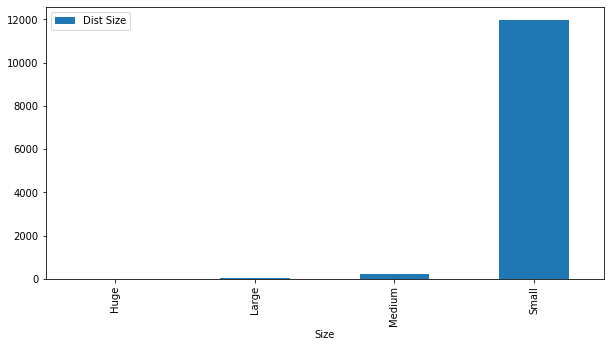

In [19]:
df_sizes = df_joined[['Size', 'Nb Inspections']].groupby('Size').count().rename(columns={'Nb Inspections' : 'Dist Size'})
df_sizes.plot.bar()
df_sizes

In [20]:
df_joined.groupby('Size').median()

,Nb Inspections,Nb Licenses,Mean Nb Violations,Mean Nb Violations of high severity,Mean Nb Violations of medium severity,Mean Nb Violations of low severity,Mean Nb Inspections,Mean Percent Passed Inspections,Mean Percent Failed Inspections
Size,,,,,,,,,
Huge,1606,240,3.415940,0.294921,0.332819,2.756963,6.781481,80.939377,19.060623
Large,216,47,3.268966,0.305263,0.372470,2.512953,5.363636,79.096045,20.903955
Medium,23,6,3.538462,0.416667,0.400000,2.758621,3.333333,77.777778,22.222222
Small,4,1,4.250000,0.333333,0.333333,3.400000,3.000000,77.777778,22.222222


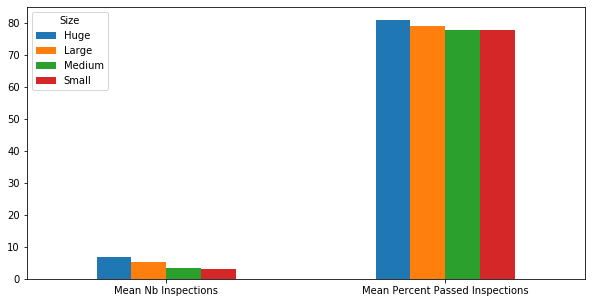

In [21]:
df_joined[['Size', 'Mean Nb Inspections', 'Mean Percent Passed Inspections']].groupby('Size').median().transpose().plot.bar(rot=0)
plt.savefig('results/figures_aka/nb_inspections_by_size.png', bbox_inches='tight')

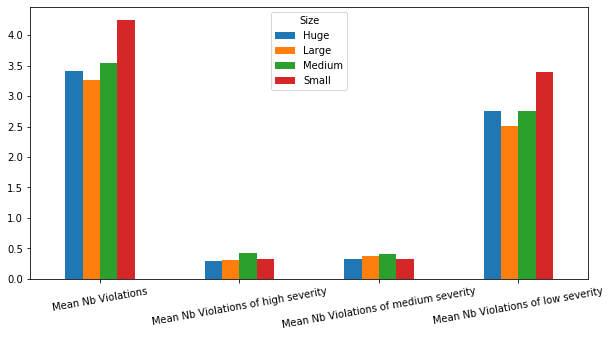

In [22]:
df_joined[['Size', 'Mean Nb Violations', 'Mean Nb Violations of high severity', 'Mean Nb Violations of medium severity', 'Mean Nb Violations of low severity']].groupby('Size').median().transpose().plot.bar(rot=10)
plt.savefig('results/figures_aka/nb_violations_by_size.png', bbox_inches='tight')

## Which ones have more addresses ? ##

In [23]:
df_joined.sort_values('Nb Licenses', ascending=False).head(15)

,Nb Inspections,Nb Licenses,Mean Nb Violations,Mean Nb Violations of high severity,Mean Nb Violations of medium severity,Mean Nb Violations of low severity,Dist Violation IDs,Dist Inspections Types,Mean Nb Inspections,Mean Percent Passed Inspections,Mean Percent Failed Inspections,Size
AKA Name,,,,,,,,,,,,
SUBWAY,3239,393,2.931460,0.354122,0.332819,2.244520,"{1: 24, 2: 162, 3: 448, 4: 11, 5: 191, 6: 53, ...","{'Canvass': 2385, 'Complaint': 571, 'Consultat...",8.241730,83.976536,16.023464,Huge
DUNKINDONUTS,1831,270,3.416712,0.294921,0.364828,2.756963,"{1: 12, 2: 89, 3: 164, 4: 3, 5: 62, 6: 52, 7: ...","{'Canvass': 1049, 'Complaint': 632, 'Consultat...",6.781481,80.939377,19.060623,Huge
STARBUCKS,1107,240,2.368564,0.178862,0.228546,1.961156,"{1: 5, 2: 25, 3: 58, 4: 2, 5: 41, 6: 3, 8: 17,...","{'Canvass': 824, 'Complaint': 125, 'Consultati...",4.612500,85.275519,14.724481,Huge
MCDONALDS,1606,175,3.415940,0.262765,0.283313,2.869863,"{1: 2, 2: 60, 3: 122, 4: 7, 5: 37, 6: 30, 7: 1...","{'Canvass': 407, 'Complaint': 1093, 'Consultat...",9.177143,78.767123,21.232877,Huge
BURGERKING,545,102,3.823853,0.308257,0.390826,3.124771,"{1: 2, 2: 13, 3: 50, 4: 2, 5: 30, 6: 10, 7: 1,...","{'Canvass': 159, 'Complaint': 315, 'License': ...",5.343137,79.816514,20.183486,Huge
KFC,389,83,3.976864,0.285347,0.316195,3.375321,"{2: 14, 3: 34, 4: 2, 5: 22, 6: 6, 8: 2, 9: 4, ...","{'Canvass': 179, 'Complaint': 148, 'License': ...",4.686747,78.663239,21.336761,Large
HAROLDSCHICKEN,344,68,4.412791,0.357558,0.494186,3.561047,"{1: 3, 2: 23, 3: 41, 5: 15, 6: 6, 9: 2, 10: 12...","{'Canvass': 76, 'Complaint': 220, 'Consultatio...",5.058824,67.441860,32.558140,Large
POPEYES,522,58,3.929119,0.327586,0.285441,3.316092,"{1: 1, 2: 15, 3: 56, 4: 1, 5: 43, 6: 6, 8: 4, ...","{'Canvass': 228, 'Complaint': 265, 'Consultati...",9.000000,79.501916,20.498084,Large
PIZZAHUT,185,57,3.816216,0.264865,0.394595,3.156757,"{2: 5, 3: 18, 5: 10, 8: 7, 10: 3, 11: 2, 12: 2...","{'Canvass': 85, 'Complaint': 55, 'Consultation...",3.245614,77.837838,22.162162,Large


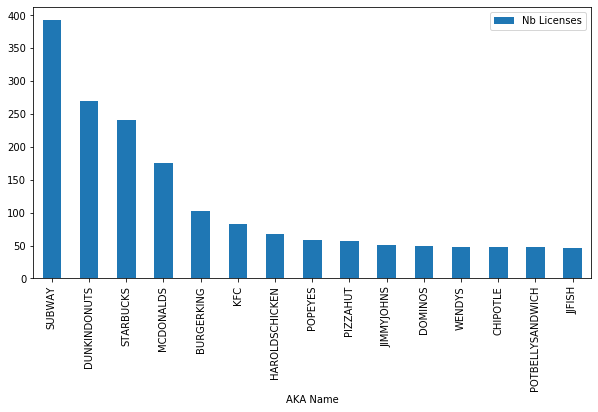

In [24]:
df_joined[['Nb Licenses']].sort_values('Nb Licenses', ascending=False).head(15).plot.bar()
plt.savefig('results/figures_aka/nb_licenses_by_aka.png', bbox_inches='tight')

## Which ones have more inspections in general ? ##

In [25]:
df_joined.sort_values('Mean Nb Inspections', ascending=False).head(15)

,Nb Inspections,Nb Licenses,Mean Nb Violations,Mean Nb Violations of high severity,Mean Nb Violations of medium severity,Mean Nb Violations of low severity,Dist Violation IDs,Dist Inspections Types,Mean Nb Inspections,Mean Percent Passed Inspections,Mean Percent Failed Inspections,Size
AKA Name,,,,,,,,,,,,
TAQUERIAELRANCHITO,31,1,6.903226,0.645161,0.548387,5.709677,"{1: 1, 2: 4, 3: 8, 4: 2, 6: 1, 8: 2, 9: 1, 11:...","{'Canvass': 4, 'Complaint': 24, 'Others': 1, '...",31.0,67.741935,32.258065,Small
RESTAURANTPOZOLERIASANJUAN,29,1,4.482759,0.172414,0.275862,4.034483,"{3: 1, 5: 2, 10: 2, 16: 1, 18: 2, 22: 1, 23: 1...","{'Canvass': 6, 'Complaint': 23}",29.0,86.206897,13.793103,Small
STAROFSIAM,28,1,4.500000,0.214286,0.357143,3.928571,"{2: 1, 3: 2, 5: 1, 8: 1, 12: 1, 16: 2, 18: 6, ...","{'Canvass': 11, 'Complaint': 14, 'Consultation...",28.0,71.428571,28.571429,Small
CHURCHSCHICKEN982,26,1,4.153846,0.384615,0.615385,3.153846,"{1: 1, 2: 1, 3: 2, 6: 1, 10: 3, 12: 2, 18: 5, ...","{'Canvass': 1, 'Complaint': 24, 'Consultation'...",26.0,65.384615,34.615385,Small
MORRISONSRESTAURANT,26,1,5.692308,0.346154,0.653846,4.692308,"{2: 1, 3: 6, 4: 1, 12: 1, 16: 1, 18: 7, 19: 1,...","{'Canvass': 1, 'Complaint': 24, 'License': 1}",26.0,65.384615,34.615385,Small
DUKSREDHOTS,25,1,4.280000,0.520000,0.320000,3.440000,"{2: 3, 3: 3, 4: 1, 5: 1, 6: 2, 7: 1, 8: 1, 13:...","{'Canvass': 6, 'Complaint': 18, 'Others': 1}",25.0,72.000000,28.000000,Small
GRANDLUXCAFE,25,1,3.760000,0.240000,0.400000,3.120000,"{3: 1, 4: 1, 5: 1, 6: 1, 8: 2, 16: 3, 18: 3, 2...","{'Complaint': 22, 'Suspect food poisoning': 3}",25.0,80.000000,20.000000,Small
CHICAGOSHOMEOFCHICKENWAFFLES,24,1,7.333333,1.291667,0.958333,5.083333,"{2: 10, 3: 12, 5: 2, 6: 1, 8: 2, 9: 1, 10: 1, ...","{'Canvass': 5, 'Complaint': 19}",24.0,58.333333,41.666667,Small
CARBON,24,1,3.458333,0.416667,0.000000,3.041667,"{3: 4, 4: 1, 5: 1, 6: 2, 8: 1, 12: 1, 30: 1, 3...","{'Canvass': 9, 'Complaint': 12, 'Consultation'...",24.0,100.000000,0.000000,Small


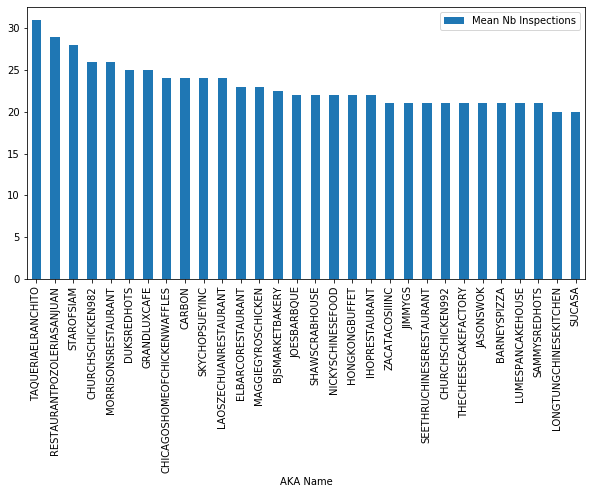

In [26]:
df_joined[['Mean Nb Inspections']].sort_values('Mean Nb Inspections', ascending=False).head(30).plot.bar()

([], <a list of 0 Text xticklabel objects>)

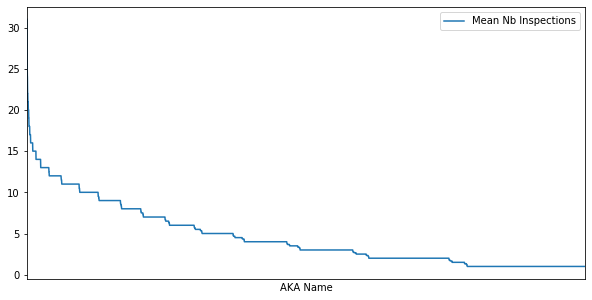

In [27]:
df_joined[['Mean Nb Inspections']].sort_values('Mean Nb Inspections', ascending=False).plot()
plt.xticks([])

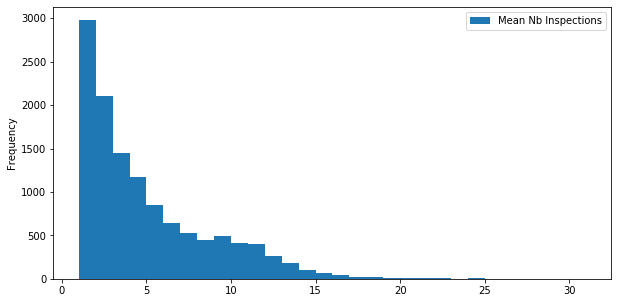

In [28]:
df_joined[['Mean Nb Inspections']].plot.hist(bins=30)

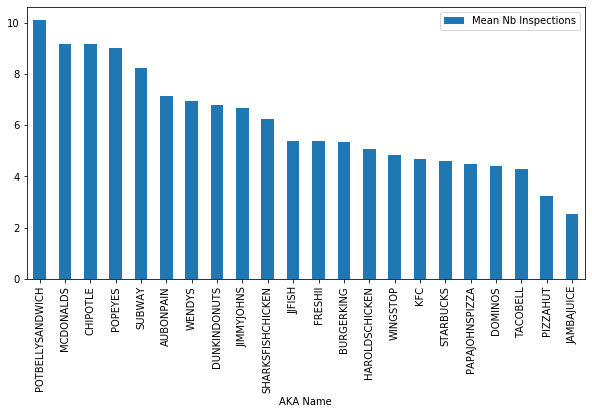

In [29]:
df_joined[df_joined['Size'].map(lambda x: x in ['Huge', 'Large'])][['Mean Nb Inspections']].sort_values('Mean Nb Inspections', ascending=False).head(30).plot.bar()

## Which ones tend to easily pass inspections ? ##

In [30]:
df_joined.sort_values('Mean Percent Passed Inspections', ascending=False).head(15)

,Nb Inspections,Nb Licenses,Mean Nb Violations,Mean Nb Violations of high severity,Mean Nb Violations of medium severity,Mean Nb Violations of low severity,Dist Violation IDs,Dist Inspections Types,Mean Nb Inspections,Mean Percent Passed Inspections,Mean Percent Failed Inspections,Size
AKA Name,,,,,,,,,,,,
BELLEMORE,4,2,3.250000,0.750000,0.000000,2.500000,"{2: 1, 3: 1, 8: 1, 30: 1, 35: 3, 38: 2, 41: 3,...","{'Canvass': 1, 'Complaint': 1, 'License': 2}",2.0,100.0,0.0,Small
JOESCOFFEE,3,1,2.000000,0.666667,0.000000,1.333333,"{3: 1, 5: 1, 31: 1, 34: 1, 35: 1, 38: 1}","{'Canvass': 2, 'License': 1}",3.0,100.0,0.0,Small
HOWARDPHILLYGRILLINC,3,1,5.333333,1.000000,0.000000,4.333333,"{3: 1, 4: 1, 12: 1, 30: 1, 33: 2, 34: 2, 35: 2...","{'Canvass': 1, 'Complaint': 2}",3.0,100.0,0.0,Small
NICKOSTACOS,3,1,4.333333,0.000000,0.333333,4.000000,"{21: 1, 30: 1, 31: 1, 32: 1, 34: 2, 35: 1, 38:...","{'Canvass': 2, 'License': 1}",3.0,100.0,0.0,Small
FLETCHERJONESAUDI,3,1,1.000000,0.666667,0.000000,0.333333,"{3: 1, 5: 1, 38: 1}","{'Canvass': 2, 'License': 1}",3.0,100.0,0.0,Small
CHINAMAX,3,1,2.666667,0.666667,0.000000,2.000000,"{3: 1, 6: 1, 32: 1, 33: 1, 35: 1, 36: 1, 38: 1...",{'Canvass': 3},3.0,100.0,0.0,Small
EASYBAR,3,1,5.666667,1.000000,0.000000,4.666667,"{3: 1, 5: 1, 10: 1, 32: 2, 33: 2, 34: 1, 35: 1...","{'Canvass': 2, 'Complaint': 1}",3.0,100.0,0.0,Small
PIZZACOSITALIANEATERY,3,1,1.000000,0.000000,0.000000,1.000000,"{33: 1, 38: 1, 45: 1}",{'Canvass': 3},3.0,100.0,0.0,Small
PIZZAFRESCA,3,1,3.666667,0.000000,0.000000,3.666667,"{32: 2, 33: 2, 34: 2, 35: 2, 36: 1, 38: 2}","{'Canvass': 2, 'License': 1}",3.0,100.0,0.0,Small


([], <a list of 0 Text xticklabel objects>)

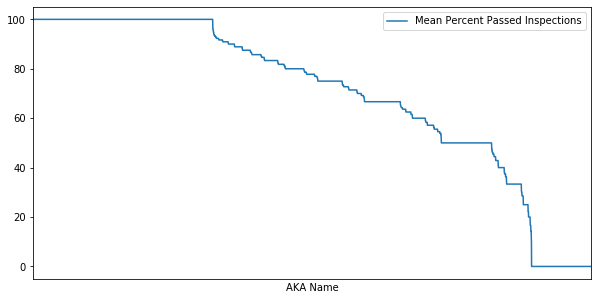

In [31]:
df_joined[['Mean Percent Passed Inspections']].sort_values('Mean Percent Passed Inspections', ascending=False).plot()
plt.xticks([])

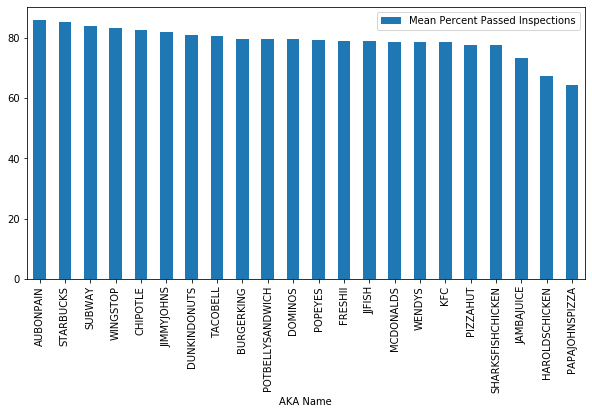

In [32]:
df_joined[df_joined['Size'].map(lambda x: x in ['Huge', 'Large'])][['Mean Percent Passed Inspections']].sort_values('Mean Percent Passed Inspections', ascending=False).head(30).plot.bar()

## Which ones tend to fail inspections ? ##

In [33]:
df_joined.sort_values('Mean Percent Failed Inspections', ascending=False).head(15)

,Nb Inspections,Nb Licenses,Mean Nb Violations,Mean Nb Violations of high severity,Mean Nb Violations of medium severity,Mean Nb Violations of low severity,Dist Violation IDs,Dist Inspections Types,Mean Nb Inspections,Mean Percent Passed Inspections,Mean Percent Failed Inspections,Size
AKA Name,,,,,,,,,,,,
BROOKLINCHICKENGRILL,1,1,5.0,1.0,1.0,3.0,"{3: 1, 25: 1, 51: 1, 56: 1, 58: 1}",{'License': 1},1.0,0.0,100.0,Small
THEWOODLAWN,1,1,9.0,2.0,0.0,7.0,"{3: 1, 5: 1, 33: 1, 36: 1, 39: 1, 48: 1, 55: 1...",{'License': 1},1.0,0.0,100.0,Small
LATINCORNERRESTAURANT,1,1,4.0,1.0,1.0,2.0,"{2: 1, 18: 1, 34: 1, 38: 1}",{'License': 1},1.0,0.0,100.0,Small
FLAVAFOOD4THESOUL,1,1,7.0,2.0,0.0,5.0,"{3: 1, 5: 1, 36: 1, 38: 1, 48: 1, 56: 1, 58: 1}",{'License': 1},1.0,0.0,100.0,Small
SPLASHCHICAGO,1,1,6.0,1.0,2.0,3.0,"{9: 1, 18: 1, 22: 1, 32: 1, 35: 1, 38: 1}",{'License': 1},1.0,0.0,100.0,Small
JERKWORLD,1,1,3.0,0.0,0.0,3.0,"{33: 1, 34: 1, 35: 1}",{'Complaint': 1},1.0,0.0,100.0,Small
ESTRELLABLANCANIGHTCLUB,1,1,12.0,5.0,1.0,6.0,"{3: 1, 5: 1, 10: 3, 16: 1, 38: 1, 49: 1, 53: 1...",{'Complaint': 1},1.0,0.0,100.0,Small
LATERRAZA,1,1,9.0,2.0,0.0,7.0,"{3: 1, 5: 1, 36: 1, 38: 1, 39: 1, 48: 1, 52: 1...",{'License': 1},1.0,0.0,100.0,Small
SPORTNUTRITION,1,1,5.0,1.0,1.0,3.0,"{2: 1, 24: 1, 37: 1, 38: 1, 40: 1}",{'License': 1},1.0,0.0,100.0,Small


([], <a list of 0 Text xticklabel objects>)

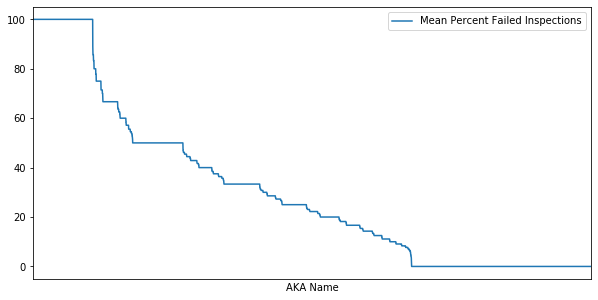

In [34]:
df_joined[['Mean Percent Failed Inspections']].sort_values('Mean Percent Failed Inspections', ascending=False).plot()
plt.xticks([])

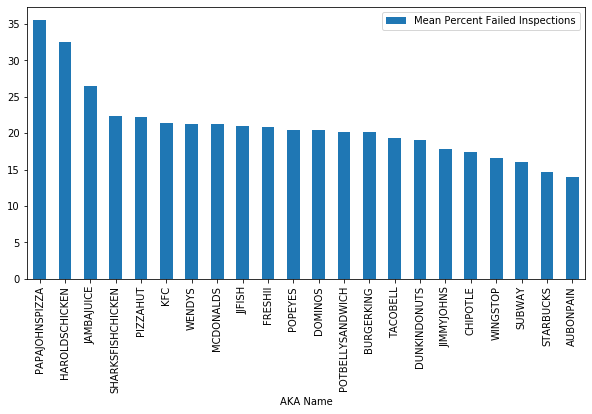

In [35]:
df_joined[df_joined['Size'].map(lambda x: x in ['Huge', 'Large'])][['Mean Percent Failed Inspections']].sort_values('Mean Percent Failed Inspections', ascending=False).head(30).plot.bar()

## Which ones have more violations by inspections ? ##

In [33]:
df_joined.sort_values('Mean Nb Violations', ascending=False).head(15)

,Nb Inspections,Nb Licenses,Mean Nb Violations,Mean Nb Violations of high severity,Mean Nb Violations of medium severity,Mean Nb Violations of low severity,Dist Violation IDs,Dist Inspections Types,Mean Nb Inspections,Mean Percent Passed Inspections,Mean Percent Failed Inspections,Size
AKA Name,,,,,,,,,,,,
SOULCRABCHICAGO,1,1,24.0,4.0,1.0,19.0,"{1: 1, 2: 1, 3: 1, 5: 1, 22: 1, 36: 1, 37: 1, ...",{'Complaint': 1},1.0,0.0,100.0,Small
BIGBITESUSHI,1,1,23.0,1.0,2.0,20.0,"{3: 1, 16: 1, 25: 1, 33: 1, 36: 1, 39: 1, 47: ...",{'License': 1},1.0,0.0,100.0,Small
DURUMCAFE,1,1,20.0,4.0,3.0,13.0,"{2: 1, 3: 1, 5: 1, 10: 1, 21: 1, 22: 1, 23: 1,...",{'Canvass': 1},1.0,0.0,100.0,Small
VENENOSINC,1,1,20.0,3.0,2.0,15.0,"{3: 1, 5: 1, 10: 1, 22: 1, 23: 1, 33: 1, 38: 1...",{'Canvass': 1},1.0,0.0,100.0,Small
LEPIANO,1,1,20.0,5.0,3.0,12.0,"{1: 1, 2: 1, 3: 1, 5: 1, 10: 1, 16: 1, 23: 1, ...",{'Canvass': 1},1.0,0.0,100.0,Small
GRANERO,1,1,20.0,2.0,4.0,14.0,"{3: 1, 5: 1, 16: 1, 22: 1, 23: 1, 25: 1, 37: 1...",{'Canvass': 1},1.0,0.0,100.0,Small
RESTAURANTLOSTAXQUENOS,1,1,20.0,5.0,0.0,15.0,"{3: 1, 5: 1, 10: 3, 33: 1, 47: 3, 48: 2, 51: 2...",{'License': 1},1.0,0.0,100.0,Small
BIRRIAOCOTLANMEZCAL,1,1,20.0,3.0,2.0,15.0,"{2: 1, 3: 1, 5: 1, 22: 1, 23: 1, 36: 1, 37: 1,...",{'Canvass': 1},1.0,0.0,100.0,Small
CHINKAY,1,1,20.0,4.0,1.0,15.0,"{2: 1, 3: 1, 5: 1, 10: 1, 25: 1, 33: 1, 36: 1,...",{'License': 1},1.0,0.0,100.0,Small


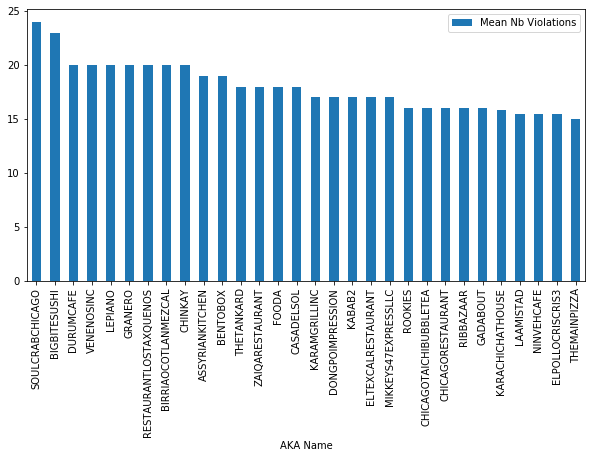

In [34]:
df_joined[['Mean Nb Violations']].sort_values('Mean Nb Violations', ascending=False).head(30).plot.bar()

([], <a list of 0 Text xticklabel objects>)

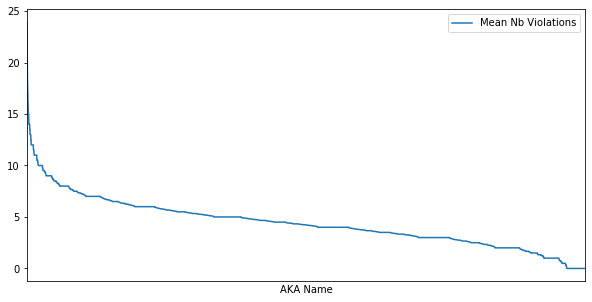

In [35]:
df_joined[['Mean Nb Violations']].sort_values('Mean Nb Violations', ascending=False).plot()
plt.xticks([])

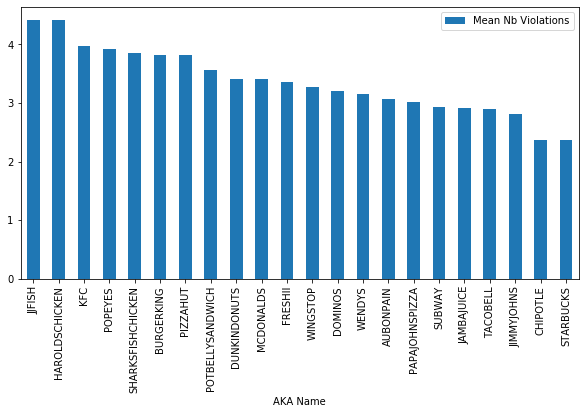

In [36]:
df_joined[df_joined['Size'].map(lambda x: x in ['Huge', 'Large'])][['Mean Nb Violations']].sort_values('Mean Nb Violations', ascending=False).head(30).plot.bar()

## How does the inspections types' distribution change depending on the size ? ##

In [37]:
def normalize_dist(dist):
    result = dist.copy()
    total = sum(dist.values())
    for key in dist.keys():
        result[key] /= total
        result[key] *= 100
    return result

def regroup_inspections_types_dists(dists):
    result = {}
    for dist in dists:
        for key, value in dist.items():
            if key in result:
                result[key] += value
            else:
                result[key] = value
    result = normalize_dist(result)
    return collections.OrderedDict(sorted(result.items()))

In [38]:
list_dists = []
for size in ['Huge', 'Large', 'Medium', 'Small']:
    dist = regroup_inspections_types_dists(df_joined[df_joined['Size'] == size]['Dist Inspections Types'].values)    
    df_dist = pd.DataFrame(dist.items(), columns=['Inspection Type', size]).set_index('Inspection Type')        
    list_dists.append(df_dist)
pd.concat(list_dists, axis=1, sort=True).plot.bar()
plt.title("Distribution of inspections' types for different sizes)
plt.savefig('results/figures_aka/dist_inspections_types_by_interesting.png', bbox_inches='tight')

SyntaxError: EOL while scanning string literal (<ipython-input-38-edb146e3d2fa>, line 7)

In [ ]:
interesting_aka_names = ['SUBWAY', 'DUNKINDONUTS', 'STARBUCKS', 'MCDONALDS', 'BURGERKING', 'KFC', 'POPEYES']
list_dists = []
for name in interesting_aka_names:
    dist = normalize_dist(df_joined.loc[name]['Dist Inspections Types'])
    df_dist = pd.DataFrame(dist.items(), columns=['Inspection Type', name]).set_index('Inspection Type')
    list_dists.append(df_dist)
pd.concat(list_dists, axis=1, sort=True).plot.bar()
plt.title("Distribution of inspections' types for well-known restaurants")
plt.savefig('results/figures_aka/dist_inspections_types_by_interesting.png', bbox_inches='tight')

## How does the violations' distribution change depending on the size ? ##

In [ ]:
violations = pd.read_csv('resources/violation-id-meaning.csv').set_index('Violation ID')
violations.head()

In [ ]:
def regroup_violation_dists(dists):
    result = {}
    for dist in dists:
        for key, value in dist.items():
            if key in result:
                result[key] += value
            else:
                result[key] = value
    result = normalize_dist(result)
    return collections.OrderedDict(sorted(result.items()))

def regroup_ids_in_categories(dist, severity=None):
    result = {}
    for key, value in dist.items():
        if key in violations.index:
            key_severity = violations.loc[key]['Severity']
            category = violations.loc[key]['Category']
        else:
            key_severity = 'Small'
            category = 'Other'
        if key_severity == severity or severity is None:
            if category in result:
                result[category] += value
            else:
                result[category] = value
    result = normalize_dist(result)
    return collections.OrderedDict(sorted(result.items()))

In [ ]:
for severity in [None, 'High', 'Medium', 'Small']:
    list_dists = []
    for size in ['Huge', 'Large', 'Medium', 'Small']:
        dist = regroup_violation_dists(df_joined[df_joined['Size'] == size]['Dist Violation IDs'].values)    
        dist_categories = regroup_ids_in_categories(dist, severity=severity)
        df_dist_categories = pd.DataFrame(dist_categories.items(), columns=['Violation Category', size]).set_index('Violation Category')
        list_dists.append(df_dist_categories)
    pd.concat(list_dists, axis=1).plot.bar()
    plt.title("Distribution of {} violations' types for different sizes".format(severity.lower() + " severity" if severity is not None else ''))
    plt.savefig('results/figures_aka/dist_{}_violations_types_by_size.png'.format(severity.lower() if severity is not None else ''), bbox_inches='tight')

## What are the violations distributions for the main ones ? ##

In [ ]:
interesting_aka_names = ['SUBWAY', 'DUNKINDONUTS', 'STARBUCKS', 'MCDONALDS', 'BURGERKING', 'KFC', 'POPEYES']
for severity in [None, 'High', 'Medium', 'Small']:
    list_dists = []
    for name in interesting_aka_names:
        dist = df_joined.loc[name]['Dist Violation IDs']
        dist_categories = regroup_ids_in_categories(dist, severity=severity)
        df_dist_categories = pd.DataFrame(dist_categories.items(), columns=['Violation Category', name]).set_index('Violation Category')
        list_dists.append(df_dist_categories)
    pd.concat(list_dists, axis=1, sort=True).plot.bar()
    plt.title("Distribution of {} violations' types for well-known restaurants".format(severity.lower() + " severity" if severity is not None else ''))
    plt.savefig('results/figures_aka/dist_{}_violations_types_by_interesting.png'.format(severity.lower() if severity is not None else ''), bbox_inches='tight')